In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias, calculate_bias_fhv, calculate_bias_flv, load_metrics
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima-boxcox": ModelHandler("ARIMA-BOXCOX",
                r"rst\ARIMA-BOXCOX",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                target_name = "qmeas",
                color = "#E69F00",
                ls = "--",
                  ),
    "arimax": ModelHandler("ARIMAX",
                r"rst\ARIMAX",
                is_final_model = True,
                is_external_model = True,
                target_name = "qmeas",
                color = "#0072B2",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     "lstm": ModelHandler("LSTM",
                   r"rst\LSTM",
                   is_final_model = True,
                   color = "#CC79A7",
                   ls = "-",
                 ),
     }


In [4]:
models = {
    "arima-boxcox": ModelHandler("ARIMA-BOXCOX",
                r"rst\ARIMA-BOXCOX",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     }


In [5]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "fhv" : calculate_bias_fhv(dfp.qmeasval.values, dfp.qsim.values),
          "flv" : calculate_bias_flv(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

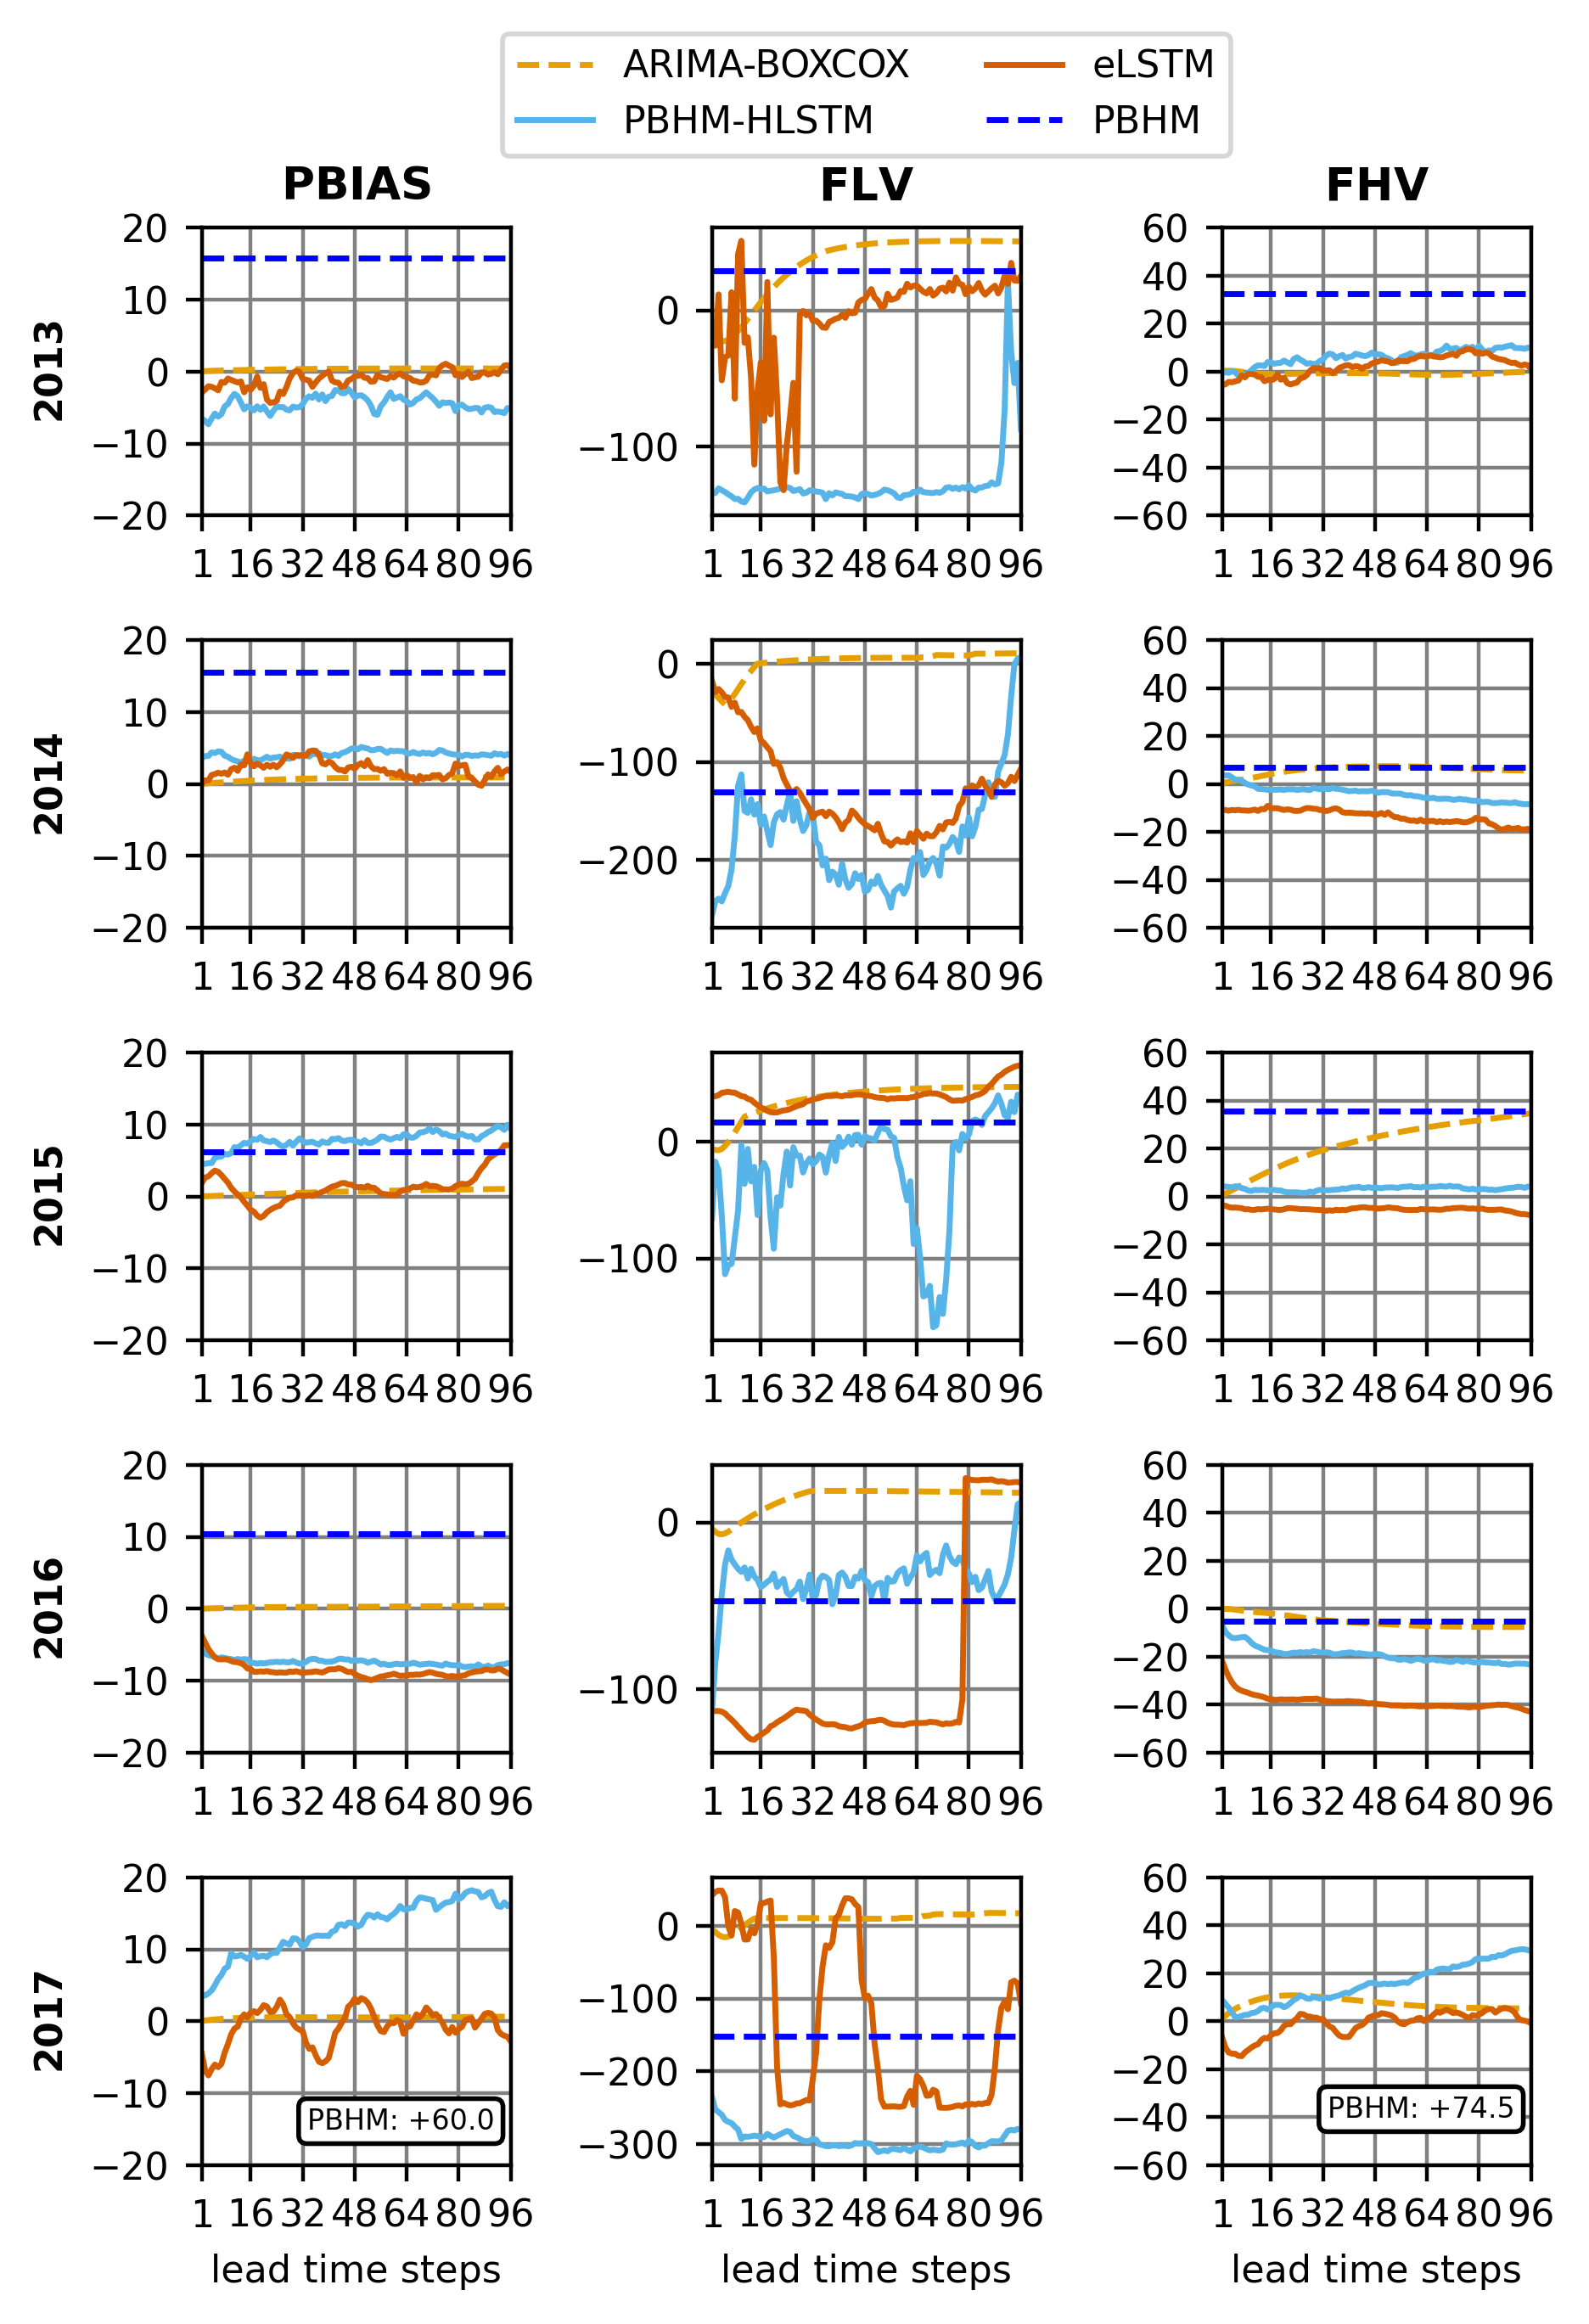

In [6]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["bias", "flv", "fhv"]
metric_labels = ["PBIAS", "FLV", "FHV"]
ylims = [(0,1), (-2,1), (-20,10)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "bias_pass", "flv_pass", "fhv_pass",
                           "bias_min", "bias_avg", "bias_max", 
                           "flv_min", "flv_avg", "flv_max", 
                           "fhv_min", "fhv_avg", "fhv_max"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    if models[key].name != "ARIMA":
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)
    else:          
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label="ARIMA", lw=1.25)


for i in range(5):
    for j in range(3):
        
        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1.25)
        if (i == 4) & (j == 0):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-15, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-40, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")
 
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        
        if j == 1:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(100))
        elif j == 0:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].set_ylim((-20,20))
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(20))
            axes[i,j].set_ylim((-60,60))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(0.5, 1.25), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [7]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'figX_leadtime_performance-bias.png'), bbox_inches="tight")

In [8]:
dft = df.drop(df.columns[2:14], axis=1)
arima   = dft.loc[0:4,:].values[:,2:]
hlstmpb = dft.loc[5:9,:].values[:,2:]
hlstm   = dft.loc[10:,:].values[:,2:]
dft

,name,year,bias_0,bias_1,bias_2,bias_3,bias_4,bias_5,bias_6,bias_7,...,fhv_86,fhv_87,fhv_88,fhv_89,fhv_90,fhv_91,fhv_92,fhv_93,fhv_94,fhv_95
0,ARIMA-BOXCOX,2013,0.038485,0.069624,0.091396,0.112313,0.129236,0.141717,0.153519,0.164575,...,-0.508383,-0.450898,-0.392185,-0.333391,-0.279187,-0.226470,-0.174485,-0.119900,-0.065469,-0.011318
1,ARIMA-BOXCOX,2014,0.038939,0.075525,0.110620,0.145182,0.177332,0.205456,0.232383,0.259132,...,5.839719,5.793820,5.756343,5.726351,5.702725,5.688428,5.673891,5.663186,5.653661,5.640614
2,ARIMA-BOXCOX,2015,0.020277,0.037922,0.054620,0.070169,0.084447,0.098391,0.112449,0.126916,...,32.999737,33.182716,33.365608,33.553377,33.746005,33.940589,34.132818,34.322829,34.512989,34.700103
3,ARIMA-BOXCOX,2016,0.023539,0.044086,0.063143,0.077974,0.088737,0.097354,0.105496,0.114365,...,-7.557014,-7.559073,-7.561154,-7.560228,-7.555019,-7.545778,-7.536069,-7.526054,-7.513581,-7.501014
4,ARIMA-BOXCOX,2017,0.060921,0.117470,0.170516,0.218188,0.260214,0.297142,0.329778,0.359335,...,5.462501,5.446501,5.427503,5.410554,5.396389,5.384881,5.373468,5.363405,5.352435,5.340759
5,PBHM-HLSTM,2013,-6.526826,-6.844705,-7.313416,-6.503647,-5.826098,-6.248445,-5.908716,-4.839562,...,10.028955,10.405003,10.724749,11.016993,9.887227,9.811046,9.802984,9.513007,10.000703,9.930877
6,PBHM-HLSTM,2014,3.628256,3.899601,3.910948,4.398593,4.310993,4.533603,4.483382,3.937116,...,-7.632536,-7.737480,-7.891601,-7.929014,-7.575767,-8.073732,-8.233419,-8.429966,-8.346376,-8.612686
7,PBHM-HLSTM,2015,4.523778,4.531414,4.627072,4.637752,5.377764,5.489890,5.551297,5.939914,...,3.014748,3.285330,3.516061,3.613462,3.783096,4.058086,3.957299,3.571518,4.140585,3.901267
8,PBHM-HLSTM,2016,-5.772713,-6.179367,-6.442326,-6.518268,-6.675568,-6.928033,-6.742284,-6.832255,...,-23.011975,-22.928942,-23.272701,-23.103902,-22.830381,-22.804210,-22.874259,-22.814600,-23.089564,-23.311399
9,PBHM-HLSTM,2017,3.728680,3.584818,3.883938,4.292668,5.023856,5.874980,6.430097,7.319768,...,27.459734,27.997818,28.750316,29.386999,29.566749,29.845079,30.081140,30.038035,29.714259,29.327539
